# Проект команды SibTeam

Данный notebook представляет собой ход работы над разработкой нейронной сети для классификации чисел.
Необходимо заменить, что нашей целью является повышение метрики accuracy, поэтому все нижеследующие действия и эксперименты будут посвящены этому

## О команде

Название команды: SibTeam<br>
Часовой пояс: +4 МСК<br>
Ментор: Александр Авдюшенко (number one)<br>
Участники:
* Калугин Константин - Тимлид
* Тимошков Александр - Ответственный за моду и сабмиты
* Филинов Дмитрий - Ответственный за сабмиты (и магию)
* Шарыпов Егор - Ответственный за сервер

## Подготовка

В рамках подготовки необходимо посмотреть на доступные нам данные, произвести первоначальную настройку и подготовить функции для последующей работы с ними

### Собираем информацию о датасете

Импортируем библиотеки, которые позже будут нами использованы

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import csv
import cv2
from PIL import Image, ImageEnhance, ImageOps
import random
import os
from livelossplot import PlotLossesKeras

2022-12-23 09:19:45.709674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 09:19:47.194338: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-23 09:19:47.194494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-23 09:19:47.194504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Считаем файлы и сохраним их содержимое в переменных

In [ ]:
for dirname, _, filenames in os.walk('kaggle/input'):
    if filenames:
        meta = pd.read_pickle(f'{dirname}/meta')
        objects_data_train = pd.read_pickle(f'{dirname}/data_train')
        objects_data_test = pd.read_pickle(f'{dirname}/data_test')
img_data_train = objects_data_train['images']
lbl_data_train = objects_data_train['labels']
img_data_test = objects_data_test['images']

Посмотрим на распределение категорий в нашем датасете

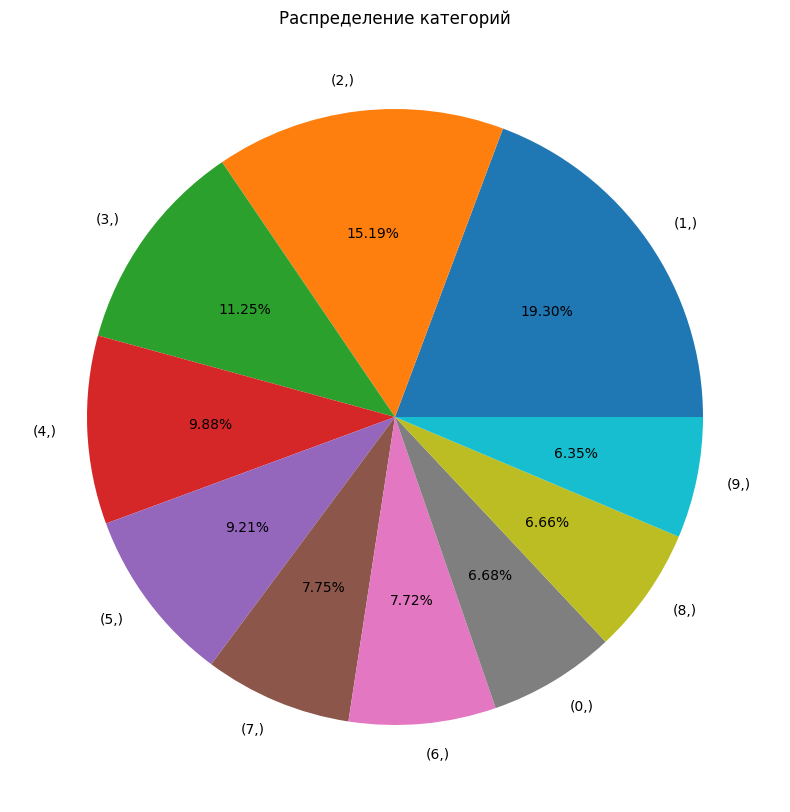

In [ ]:
plt.figure(figsize = (20,10))

plt.pie(pd.DataFrame(lbl_data_train).value_counts(), labels = pd.DataFrame(lbl_data_train).value_counts().index, autopct = '%1.2f%%')
plt.title('Распределение категорий')

plt.show()

По данной диаграмме мы видим неоднородность распределения, но она некритична

Посмотрим на трейновый и тестовый датасеты, а именно на изображения

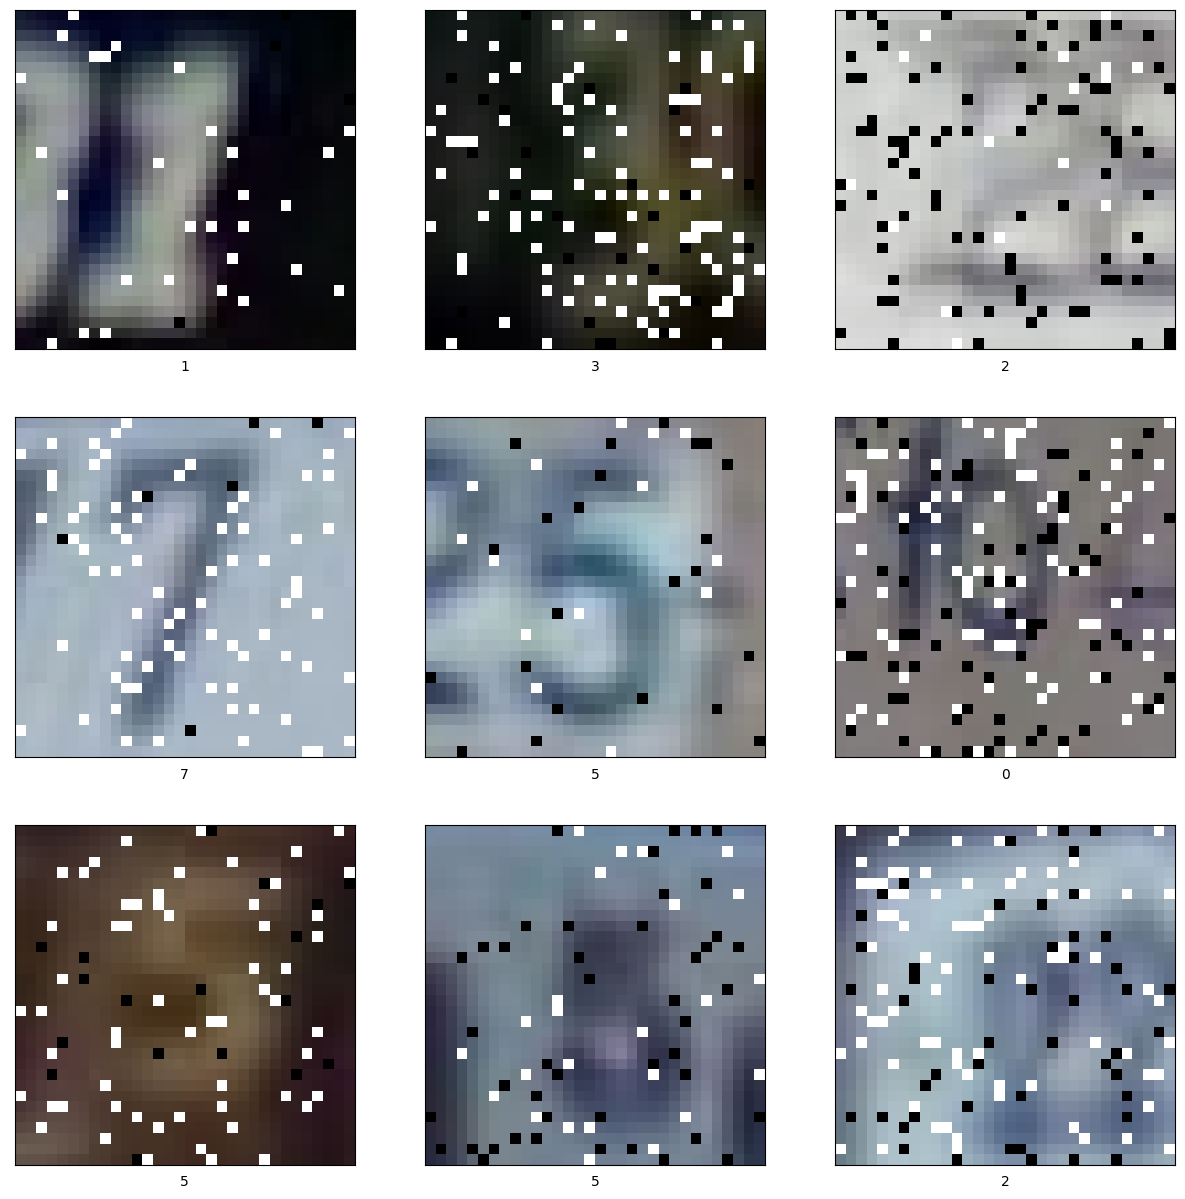

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_data_train[i] / 255.0, cmap=plt.cm.binary)
    plt.xlabel(lbl_data_train[i])
plt.show()

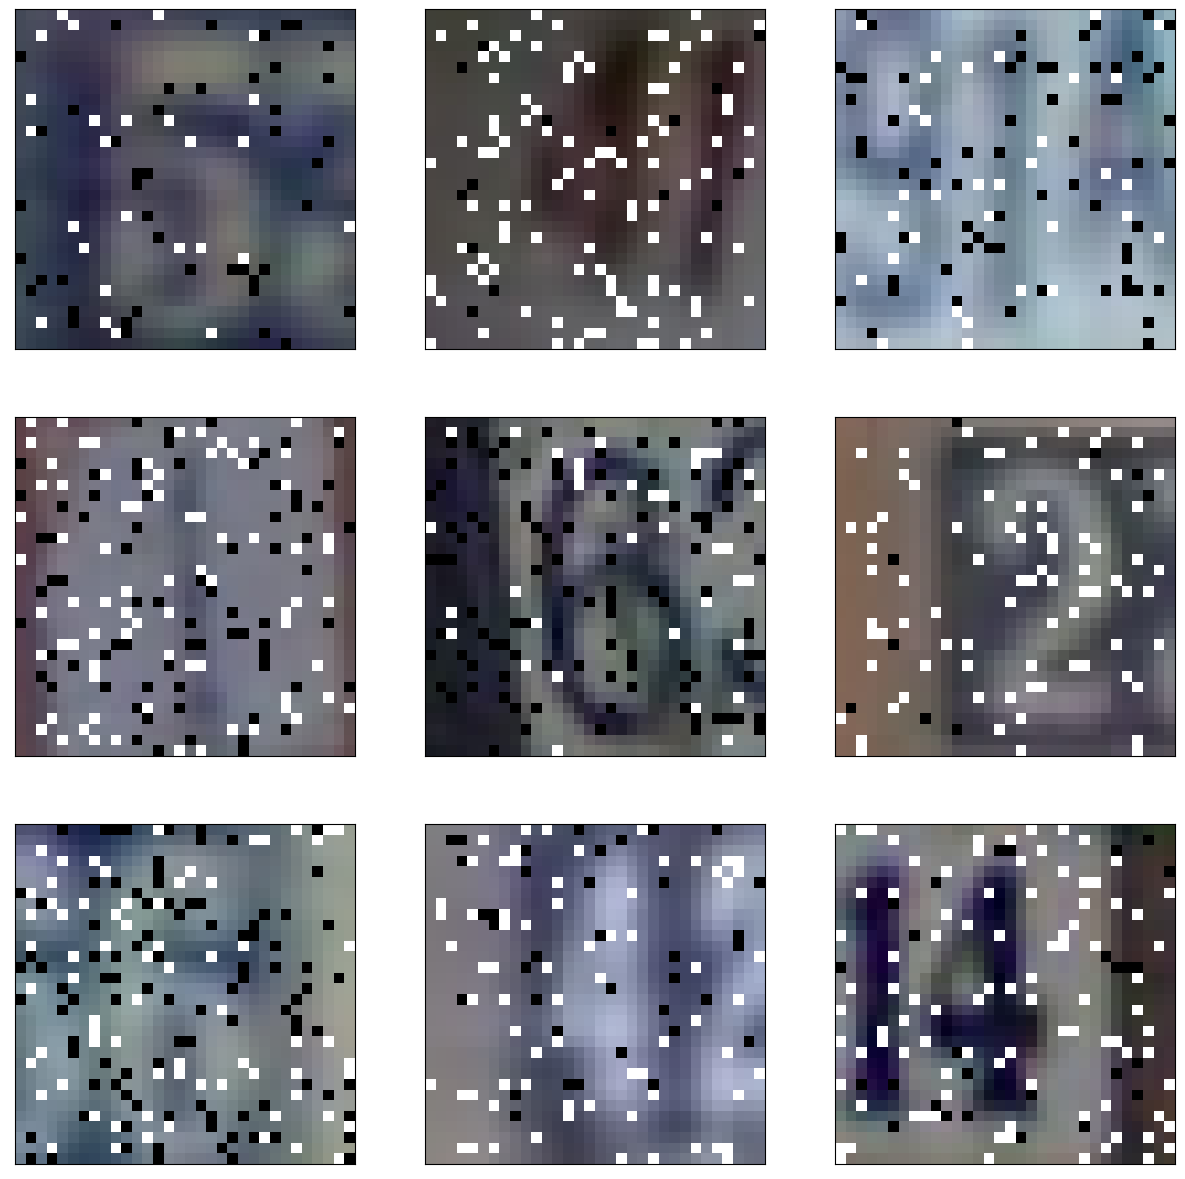

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_data_test[i] / 255.0, cmap=plt.cm.binary)
plt.show()

Очевидно, что изображения зашумлены, "соль-перец" потребуется в дальнейшем удалить

### Используем cuda

Для наивысшей скорости весь процесс обучения следует производить на cuda-ядрах

In [ ]:
os.environ["CUDA_PATH"] = "/usr/lib/cuda"
os.environ["CUDA_DIR"] = "/usr/lib/cuda"

### Создадим несколько функций

Очевидно, что писать каждый раз один и тот же код будет неэффективно, поэтому требуется написать для этих кусков кода отдельные функции

Ниже представлена функция, которая выводит графики точности наших моделей

In [ ]:
def show_results(model_history):
    acc = model_history.history["accuracy"]
    val_acc = model_history.history['val_accuracy']
    plt.figure(figsize=(16, 8))
    plt.plot(np.arange(1, len(acc) + 1), acc, label='Training Accuracy')
    plt.plot(np.arange(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training Accuracy')
    plt.show()

Ниже представлена функция, которая сохраняет предсказания моделей

In [ ]:
def save_test_pred(model, num):
    predicts = model.predict(img_data_test / 255.0)
    dict_pred = {}
    for i in range(len(predicts)):
        dict_pred[i] = np.argmax(predicts[i])
    with open(f'outputs/output{num}.csv', 'w', newline='') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar=',', quoting=csv.QUOTE_MINIMAL)
        spamwriter.writerow(['Id', 'Category'])
        for key in list(dict_pred.keys()):
            spamwriter.writerow([key, dict_pred[key]])

## Разработка моделей

Данный пункт содержит все модели, разработанные в ходе работы над проектом, и необходимые для их улучшения технологии

### Базовая модель

Данный пункт содержит начальную базовую модель и ее производные

#### Базовая модель

Делим весь трейновый датасет на трейн и валидацию

In [ ]:
train_images, validation_images, train_labels, validation_labels = train_test_split(img_data_train / 255.0, lbl_data_train, test_size=0.01)

Задаем датасеты для модели

In [ ]:
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

val_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

2022-12-23 09:20:00.410205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 09:20:01.283860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38230 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0


In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 1024, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)

val_dataset = val_dataset.batch(batch_size)

Ниже представлена архитектура самой простой базовой модели

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),    
    tf.keras.layers.Dense(10,  activation='softmax')
])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=8)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('kaggle/working/best_cnn.h5', save_best_only=True)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

Обучаем

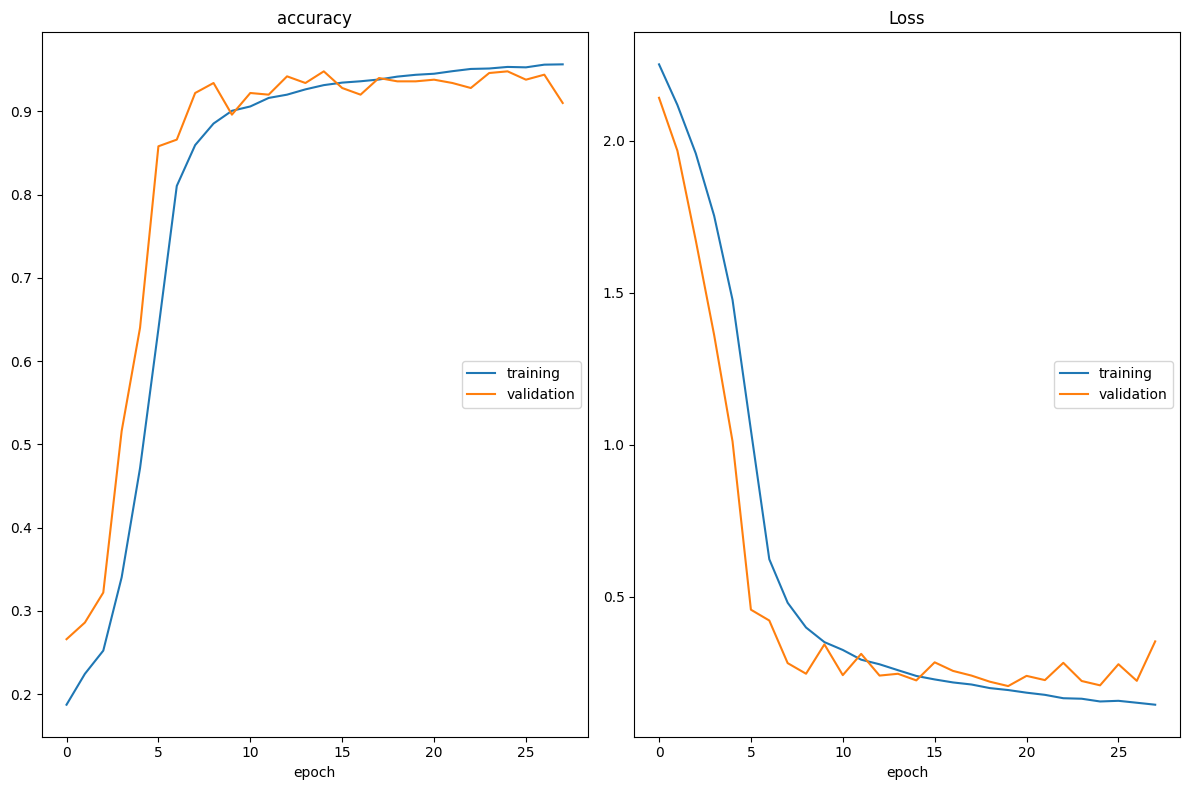

accuracy
	training         	 (min:    0.187, max:    0.956, cur:    0.956)
	validation       	 (min:    0.266, max:    0.948, cur:    0.910)
Loss
	training         	 (min:    0.145, max:    2.251, cur:    0.145)
	validation       	 (min:    0.207, max:    2.141, cur:    0.354)


In [ ]:
model_history1 = model.fit(train_dataset, validation_data=val_dataset, epochs=70, callbacks=[early_stopping, model_checkpoint, PlotLossesKeras()], verbose=False)

Смотрим на точность

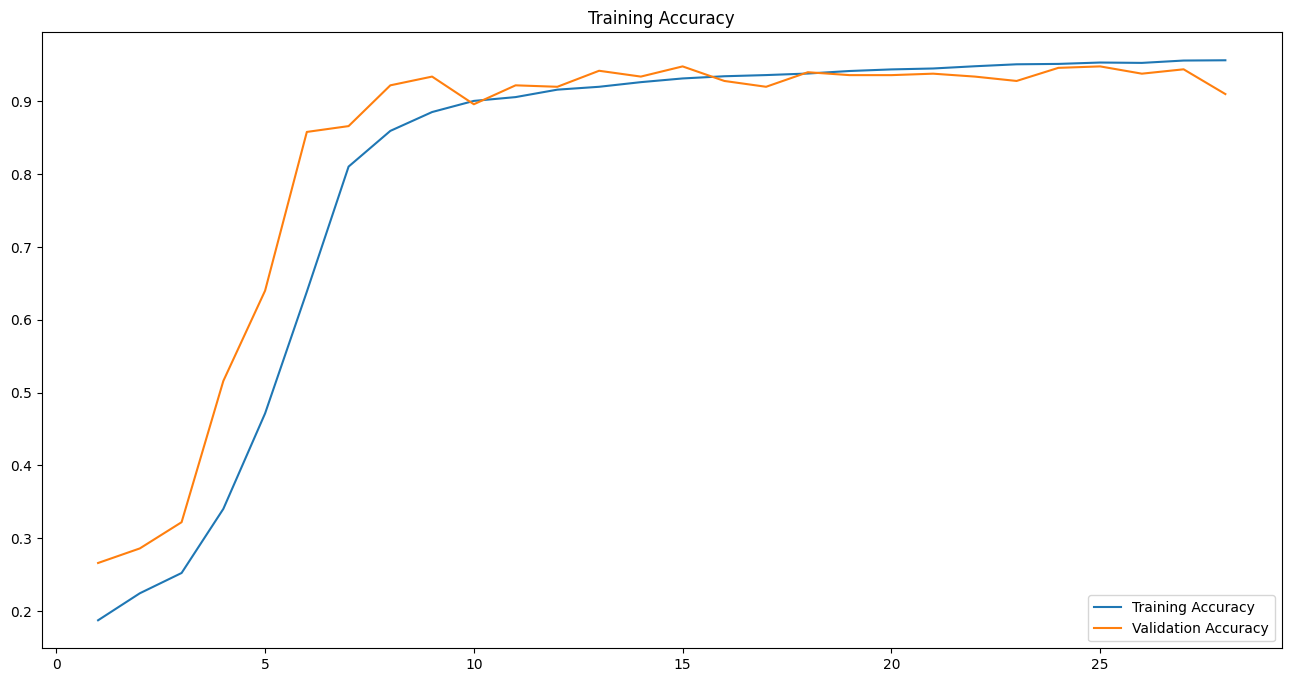

In [ ]:
show_results(model_history1)

По графику мы видим, что точность нашей модели растет достаточно быстро, но застревает у значения ~0.9, что нужно будет в будущем исправить. Если говорить о результатах на тесте, то там accuracy вышел приблизительно 0.92, что является отличным началом

Сохраняем предсказания модели на тесте

In [ ]:
save_test_pred(model, 0)

782/782 [==============================] - 4s 4ms/step


#### Базовая модель с аугментацией

Выполним уже знакомые операции

In [ ]:
train_images, validation_images, train_labels, validation_labels = train_test_split(img_data_train / 255.0, lbl_data_train, test_size=0.01)

In [ ]:
batch_size = 512

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

val_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 1024, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)

val_dataset = val_dataset.batch(batch_size)

Создадим модель аугментации, которая случайно поворачивает изображения и флипает их по горизонтальной оси

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
])
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Ниже уже знакомая архитектура

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),    
    tf.keras.layers.Dense(10,  activation='softmax')
])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=8)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

Вновь выполним уже стандартные действия

In [ ]:
model_history2 = model.fit(train_dataset, validation_data=val_dataset, epochs=70, callbacks=[early_stopping], verbose=False)

2022-12-23 09:24:50.123509: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


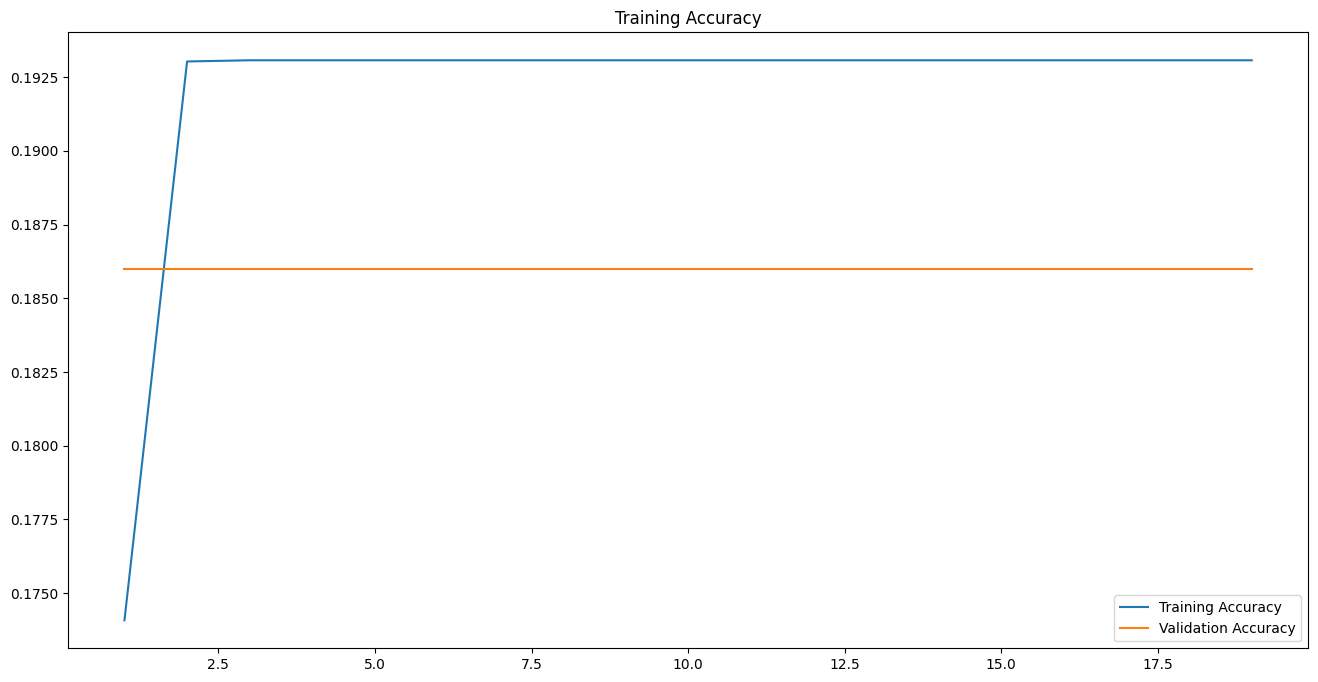

In [ ]:
show_results(model_history2)

Вышло очень интересно, мы добавили аугментацию для улучшения нашей модели, однако результат только ухудшился (очень сильно). К этому вопросу необходимо еще вернуться

In [ ]:
save_test_pred(model, 1)

782/782 [==============================] - 3s 4ms/step


#### Базовая модель со skip-connection

Выполняем стандартные действия

In [ ]:
train_images, validation_images, train_labels, validation_labels = train_test_split(img_data_train / 255.0, lbl_data_train, test_size=0.01)

In [ ]:
batch_size = 512

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

val_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 1024, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)

val_dataset = val_dataset.batch(batch_size)

Ниже представлена новая архитектура, теперь после каждого maxpool можно либо сразу перейти к dropout, либо через дополнительный conv2d, это должно снизить переобучение и, соответственно, повысить точность на тесте

In [ ]:
tf.keras.backend.clear_session()
inp =  tf.keras.layers.Input(shape=(32, 32, 3))
la1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3))(inp)
la2 = tf.keras.layers.BatchNormalization()(la1)
la3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la2)
la4 = tf.keras.layers.MaxPooling2D((2, 2))(la3)
laforadd1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la4)
add1 = tf.keras.layers.Add()([la4, laforadd1])
la5 = tf.keras.layers.Dropout(0.3)(add1)
la6 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la5)
la7 = tf.keras.layers.BatchNormalization()(la6)
la8 = tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu')(la7)
la9 = tf.keras.layers.MaxPooling2D((2, 2))(la8)
laforadd2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la9)
add2 = tf.keras.layers.Add()([la9, laforadd2])
la10 = tf.keras.layers.Dropout(0.3)(add2)
la11 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la10)
la12 = tf.keras.layers.BatchNormalization()(la11)
la13 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu')(la12)
la14 = tf.keras.layers.MaxPooling2D((2, 2))(la13)
laforadd3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la14)
add3 = tf.keras.layers.Add()([la14, laforadd3])
la15 = tf.keras.layers.Dropout(0.3)(add3)
la16 = tf.keras.layers.Flatten()(la15)
la17 = tf.keras.layers.Dense(128, activation='relu')(la16)
la18 = tf.keras.layers.Dropout(0.4)(la17)
la19 = tf.keras.layers.Dense(10,  activation='softmax')(la18)
model = tf.keras.Model(inputs=inp, outputs=la19)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=8)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['batch_normalization[0][0]']

Далее вновь идут стандартные действия

In [ ]:
model_history3 = model.fit(train_dataset, validation_data=val_dataset, epochs=70, callbacks=[early_stopping], verbose=False)

2022-12-23 09:34:28.002741: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


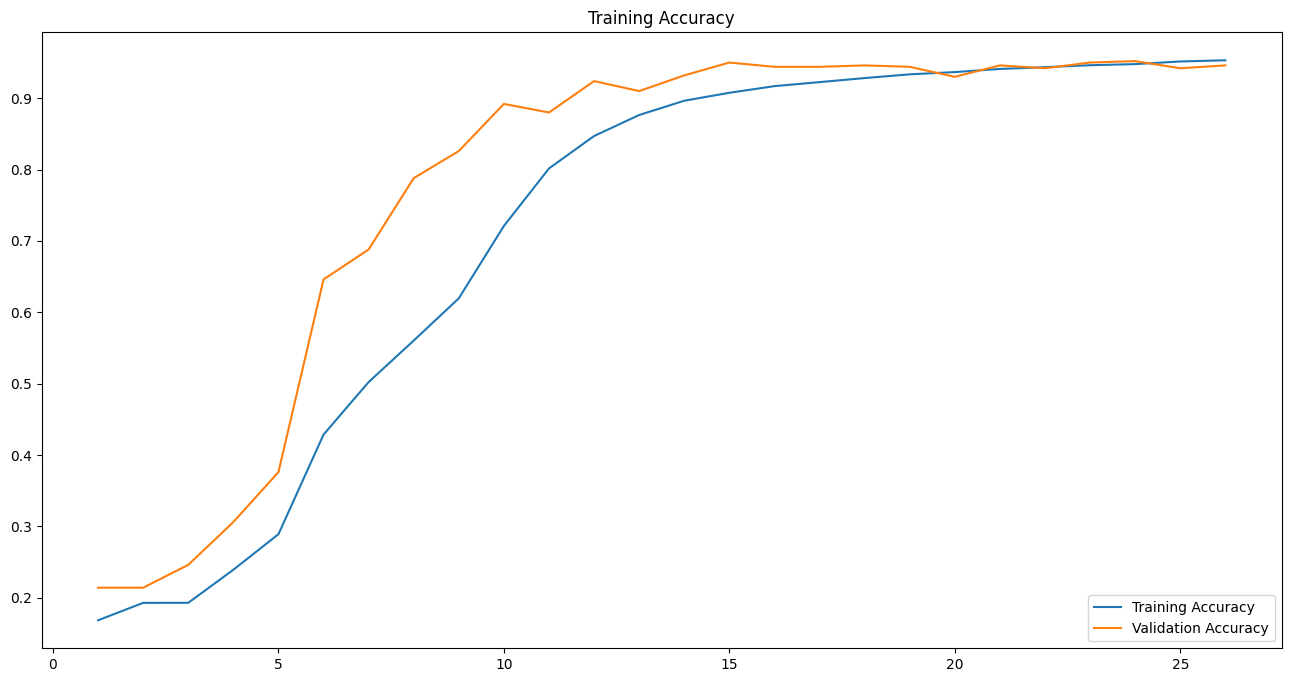

In [ ]:
show_results(model_history3)

Что же, ожидания подтвердились, точность немного выросла по сравнению с первой моделью, результат на тесте составил приблизительно 0.927!

In [ ]:
save_test_pred(model, 2)

782/782 [==============================] - 4s 4ms/step


#### Базовая модель со skip-connection и аугментацией

In [ ]:
train_images, validation_images, train_labels, validation_labels = train_test_split(img_data_train / 255.0, lbl_data_train, test_size=0.01)

In [ ]:
batch_size = 512

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

val_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 1024, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)

val_dataset = val_dataset.batch(batch_size)

Вновь мы возвращаемся к модели аугментации, из-за которой одна из предыдущих моделей показала относительно низкие результаты. Посмотрим, исправится ли ситуация

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
])
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
tf.keras.backend.clear_session()
inp =  tf.keras.layers.Input(shape=(32, 32, 3))
la1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3))(inp)
la2 = tf.keras.layers.BatchNormalization()(la1)
la3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la2)
la4 = tf.keras.layers.MaxPooling2D((2, 2))(la3)
laforadd1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la4)
add1 = tf.keras.layers.Add()([la4, laforadd1])
la5 = tf.keras.layers.Dropout(0.3)(add1)
la6 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la5)
la7 = tf.keras.layers.BatchNormalization()(la6)
la8 = tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu')(la7)
la9 = tf.keras.layers.MaxPooling2D((2, 2))(la8)
laforadd2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la9)
add2 = tf.keras.layers.Add()([la9, laforadd2])
la10 = tf.keras.layers.Dropout(0.3)(add2)
la11 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la10)
la12 = tf.keras.layers.BatchNormalization()(la11)
la13 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu')(la12)
la14 = tf.keras.layers.MaxPooling2D((2, 2))(la13)
laforadd3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la14)
add3 = tf.keras.layers.Add()([la14, laforadd3])
la15 = tf.keras.layers.Dropout(0.3)(add3)
la16 = tf.keras.layers.Flatten()(la15)
la17 = tf.keras.layers.Dense(128, activation='relu')(la16)
la18 = tf.keras.layers.Dropout(0.4)(la17)
la19 = tf.keras.layers.Dense(10,  activation='softmax')(la18)
model = tf.keras.Model(inputs=inp, outputs=la19)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=8)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['batch_normalization[0][0]']

In [ ]:
model_history4 = model.fit(train_dataset, validation_data=val_dataset, epochs=70, callbacks=[early_stopping], verbose=False)

2022-12-23 09:35:52.301277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


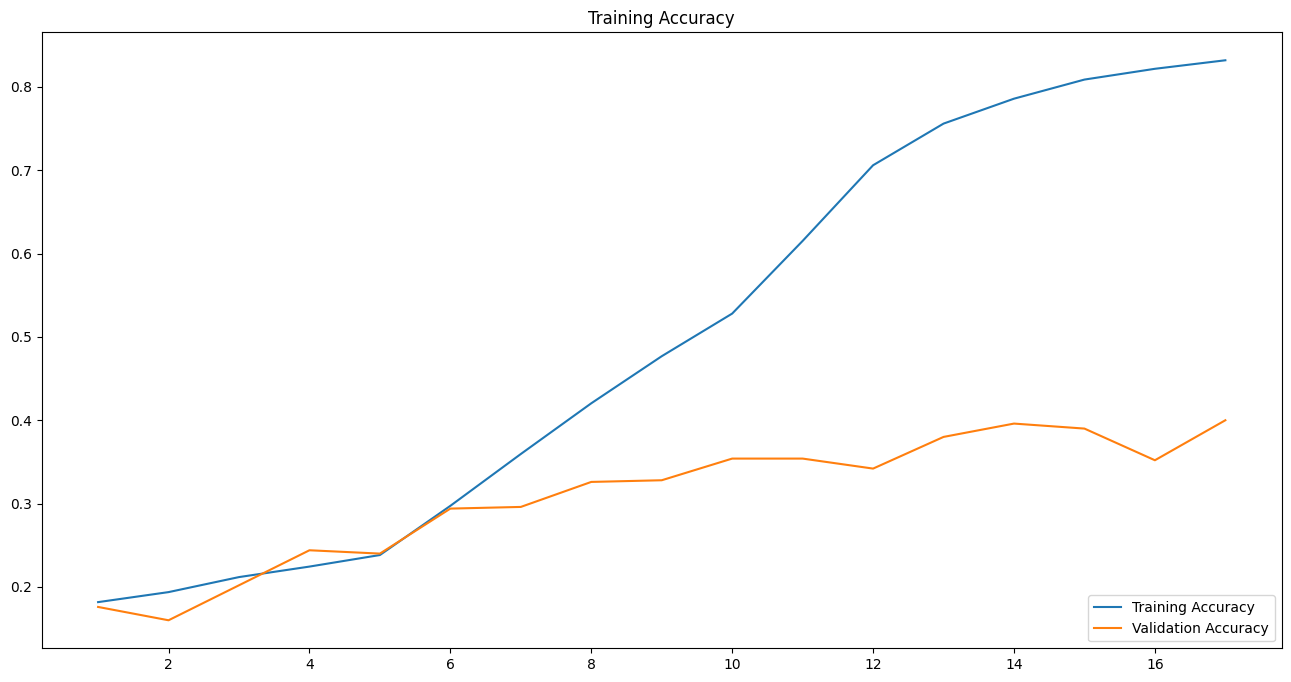

In [ ]:
show_results(model_history4)

И опять аугментация нас подвела, мы можем убедиться, что использован абсолютно неверный подход

In [ ]:
save_test_pred(model, 3)

782/782 [==============================] - 4s 4ms/step


#### Про аугментацию

Мы дважды пытались использовать аугментацию и все попытки были неудачны. Поэтому мы решили сделать небольшой разбор полетов и выделили основные ошибки, которые были допущены в ходе разработки:
Т.к. мы работаем с изображениями цифр, то мы их не имеем право флипать, т.к. они пишутся в строгом соответствии правилам начертания арабских цифр, поэтому мы никогда не встретим цифр, которые пишутся в зеркальном отражении. Также стоит отметить, что флипы относительно горизонтальной оси могут еще и путать нашу нейронную сеть (6 -> 9, 9 -> 6 и т.д.)
Исходя из этого мы понимаем, что наш метод аугментации находится в плачевном состоянии, поэтому надо координально менять подход, что мы и сделаем немного ниже

#### Базовая модель со skip-connection, удалением шума

Теперь, когда мы протестировали различные вариации базовой модели, мы можем перейти к очистке данных от шума. Ниже представлен код, который с помощью медианного фильтра убирает "соль-перец" и на трейне, и на тесте. Все остальные действия для нас уже стали стандартными

In [ ]:
for i in range(len(img_data_train)):
    img_data_train[i] = cv2.medianBlur(img_data_train[i], 3)

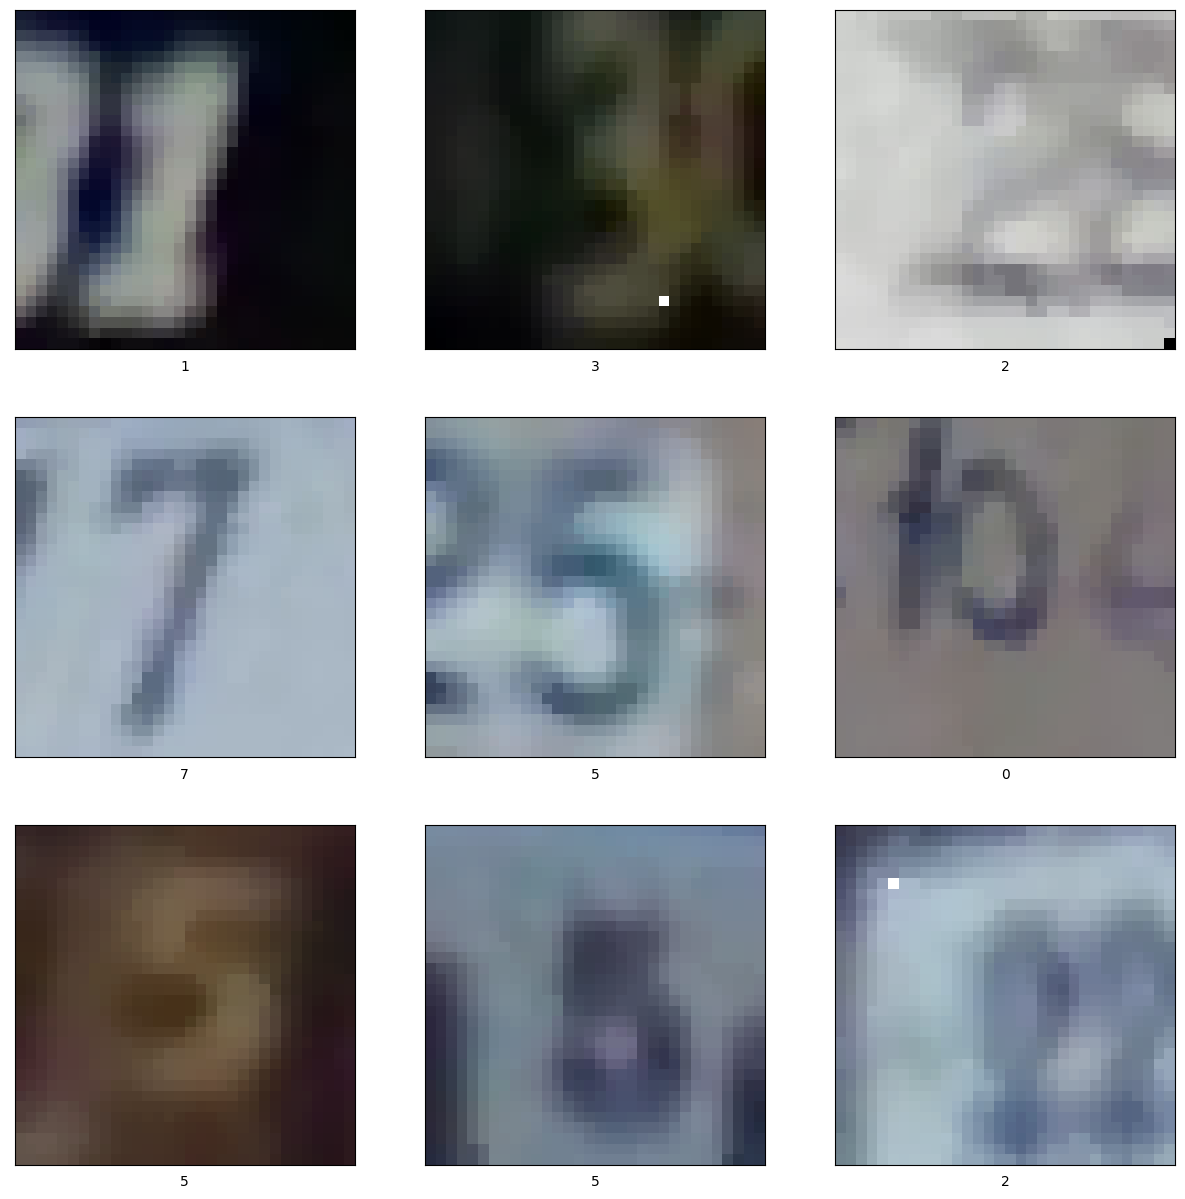

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_data_train[i] / 255.0, cmap=plt.cm.binary)
    plt.xlabel(lbl_data_train[i])
plt.show()

In [ ]:
for i in range(len(img_data_test)):
    img_data_test[i] = cv2.medianBlur(img_data_test[i], 3)

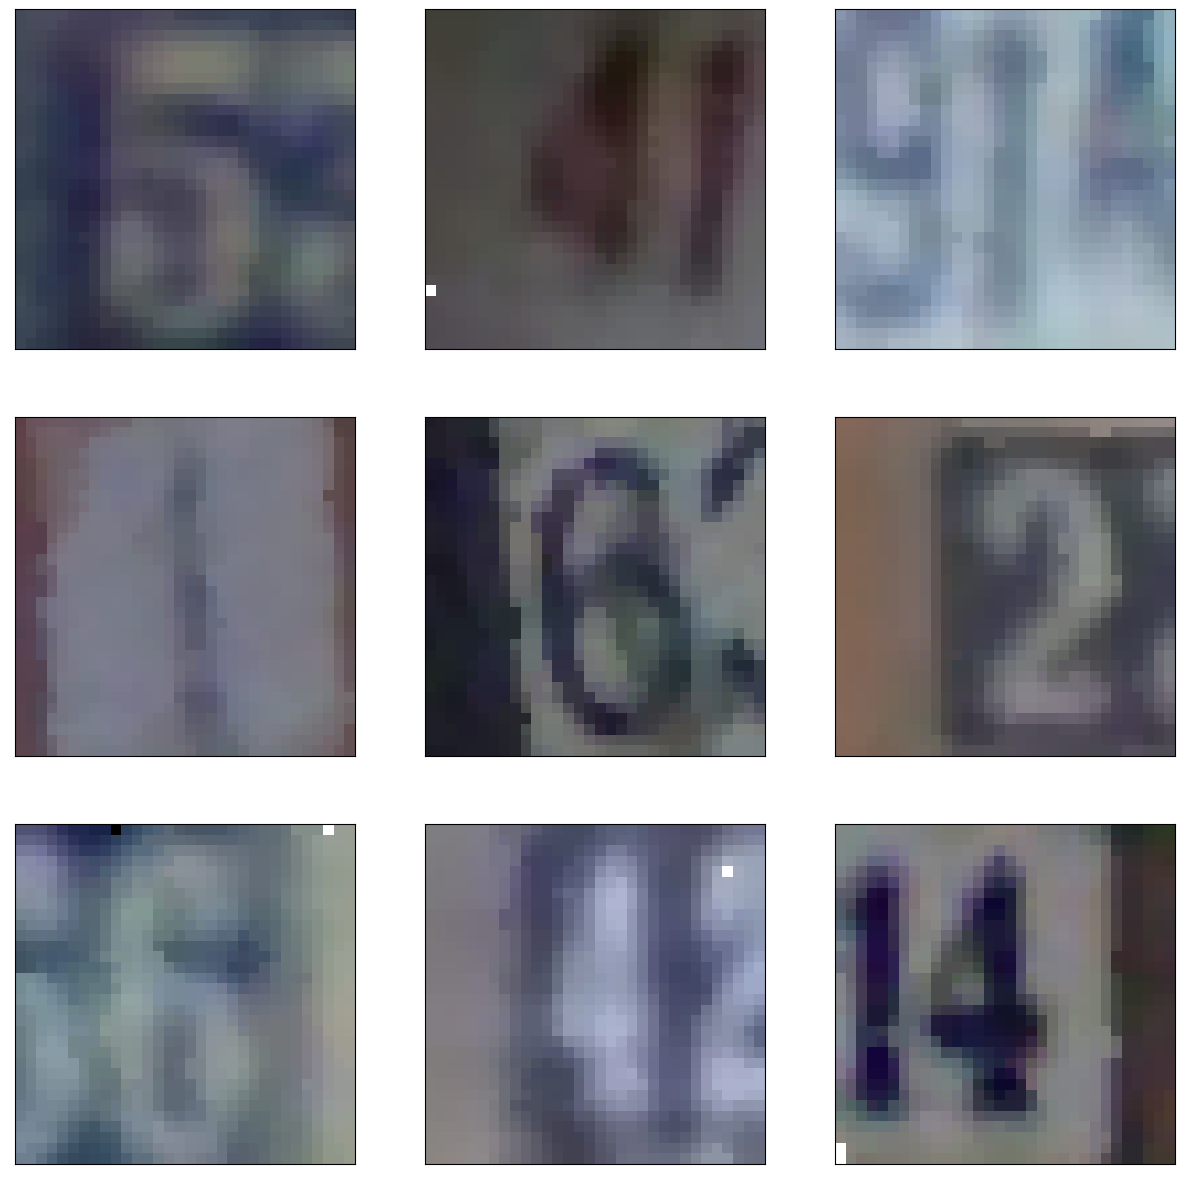

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_data_test[i] / 255.0, cmap=plt.cm.binary)
plt.show()

In [ ]:
train_images, validation_images, train_labels, validation_labels = train_test_split(img_data_train / 255.0, lbl_data_train, test_size=0.01)

In [ ]:
batch_size = 512

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

val_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 1024, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)

val_dataset = val_dataset.batch(batch_size)

In [ ]:
tf.keras.backend.clear_session()
inp =  tf.keras.layers.Input(shape=(32, 32, 3))
la1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3))(inp)
la2 = tf.keras.layers.BatchNormalization()(la1)
la3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la2)
la4 = tf.keras.layers.MaxPooling2D((2, 2))(la3)
laforadd1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la4)
add1 = tf.keras.layers.Add()([la4, laforadd1])
la5 = tf.keras.layers.Dropout(0.3)(add1)
la6 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la5)
la7 = tf.keras.layers.BatchNormalization()(la6)
la8 = tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu')(la7)
la9 = tf.keras.layers.MaxPooling2D((2, 2))(la8)
laforadd2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la9)
add2 = tf.keras.layers.Add()([la9, laforadd2])
la10 = tf.keras.layers.Dropout(0.3)(add2)
la11 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la10)
la12 = tf.keras.layers.BatchNormalization()(la11)
la13 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu')(la12)
la14 = tf.keras.layers.MaxPooling2D((2, 2))(la13)
laforadd3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la14)
add3 = tf.keras.layers.Add()([la14, laforadd3])
la15 = tf.keras.layers.Dropout(0.3)(add3)
la16 = tf.keras.layers.Flatten()(la15)
la17 = tf.keras.layers.Dense(128, activation='relu')(la16)
la18 = tf.keras.layers.Dropout(0.4)(la17)
la19 = tf.keras.layers.Dense(10,  activation='softmax')(la18)
model = tf.keras.Model(inputs=inp, outputs=la19)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=8)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['batch_normalization[0][0]']

In [ ]:
model_history5 = model.fit(train_dataset, validation_data=val_dataset, epochs=70, callbacks=[early_stopping], verbose=False)

2022-12-23 09:45:03.178023: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


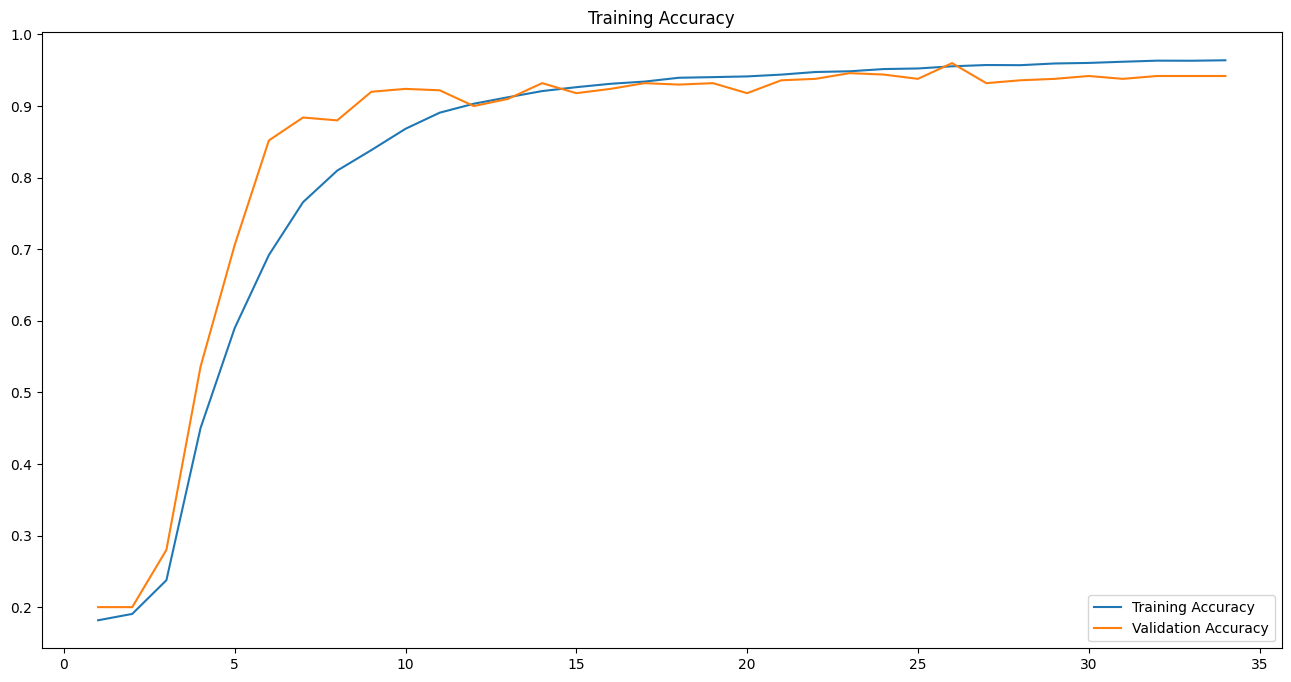

In [ ]:
show_results(model_history5)

Как и ожидалось, с более чистыми данными у нас улучшилась точность, к чему мы и стремились. Тест - 0.931

In [ ]:
save_test_pred(model, 4)

782/782 [==============================] - 4s 4ms/step


#### Базовая модель со skip-connection, удалением шума и датагеном

В предыдущем эксперименте мы уже почистили изображения от шума, поэтому мы только добавим агументацию

Все прошлые попытки добавить аугментацию не увенчались успехом, это может быть связано с неправильной реализацией данного метода. Действительно, каждый раз мы отзеркаливали изображения и немного их поворачивали, что для цифр абсолютно некорректно, т.к. они хоть и могут быть немного наклонены, но не могут писаться в другую сторону, поэтому используем imagedatagenerator, в котором укажем другие методы аугментации

В этот раз используются повороты, зум и различные сдвиги

In [ ]:
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [ ]:
tf.keras.backend.clear_session()
inp =  tf.keras.layers.Input(shape=(32, 32, 3))
la1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3))(inp)
la2 = tf.keras.layers.BatchNormalization()(la1)
la3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la2)
la4 = tf.keras.layers.MaxPooling2D((2, 2))(la3)
laforadd1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la4)
add1 = tf.keras.layers.Add()([la4, laforadd1])
la5 = tf.keras.layers.Dropout(0.3)(add1)
la6 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la5)
la7 = tf.keras.layers.BatchNormalization()(la6)
la8 = tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu')(la7)
la9 = tf.keras.layers.MaxPooling2D((2, 2))(la8)
laforadd2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la9)
add2 = tf.keras.layers.Add()([la9, laforadd2])
la10 = tf.keras.layers.Dropout(0.3)(add2)
la11 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la10)
la12 = tf.keras.layers.BatchNormalization()(la11)
la13 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu')(la12)
la14 = tf.keras.layers.MaxPooling2D((2, 2))(la13)
laforadd3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la14)
add3 = tf.keras.layers.Add()([la14, laforadd3])
la15 = tf.keras.layers.Dropout(0.3)(add3)
la16 = tf.keras.layers.Flatten()(la15)
la17 = tf.keras.layers.Dense(128, activation='relu')(la16)
la18 = tf.keras.layers.Dropout(0.4)(la17)
la19 = tf.keras.layers.Dense(10,  activation='softmax')(la18)
model = tf.keras.Model(inputs=inp, outputs=la19)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=8)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['batch_normalization[0][0]']

In [ ]:
model_history6 = model.fit_generator(datagen.flow(train_images, train_labels, batch_size=batch_size),
                                  epochs=70, validation_data=(validation_images, validation_labels),
                                  callbacks=[early_stopping, model_checkpoint])

/tmp/ipykernel_724015/560266036.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history6 = model.fit_generator(datagen.flow(train_images, train_labels, batch_size=batch_size),


Epoch 1/70


2022-12-23 09:46:38.214254: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


97/97 [==============================] - 44s 380ms/step - loss: 2.3896 - accuracy: 0.1755 - val_loss: 2.2576 - val_accuracy: 0.1980
Epoch 2/70
97/97 [==============================] - 36s 373ms/step - loss: 2.2135 - accuracy: 0.1912 - val_loss: 2.2634 - val_accuracy: 0.2000
Epoch 3/70
97/97 [==============================] - 36s 373ms/step - loss: 1.9823 - accuracy: 0.2445 - val_loss: 2.1850 - val_accuracy: 0.2920
Epoch 4/70
97/97 [==============================] - 35s 358ms/step - loss: 1.7043 - accuracy: 0.3681 - val_loss: 1.6170 - val_accuracy: 0.4480
Epoch 5/70
97/97 [==============================] - 36s 373ms/step - loss: 1.4403 - accuracy: 0.4642 - val_loss: 1.1923 - val_accuracy: 0.6200
Epoch 6/70
97/97 [==============================] - 36s 375ms/step - loss: 1.1505 - accuracy: 0.5869 - val_loss: 0.6675 - val_accuracy: 0.8140
Epoch 7/70
97/97 [==============================] - 36s 373ms/step - loss: 0.9302 - accuracy: 0.6825 - val_loss: 0.5044 - val_accuracy: 0.8540
Epoch 8/70

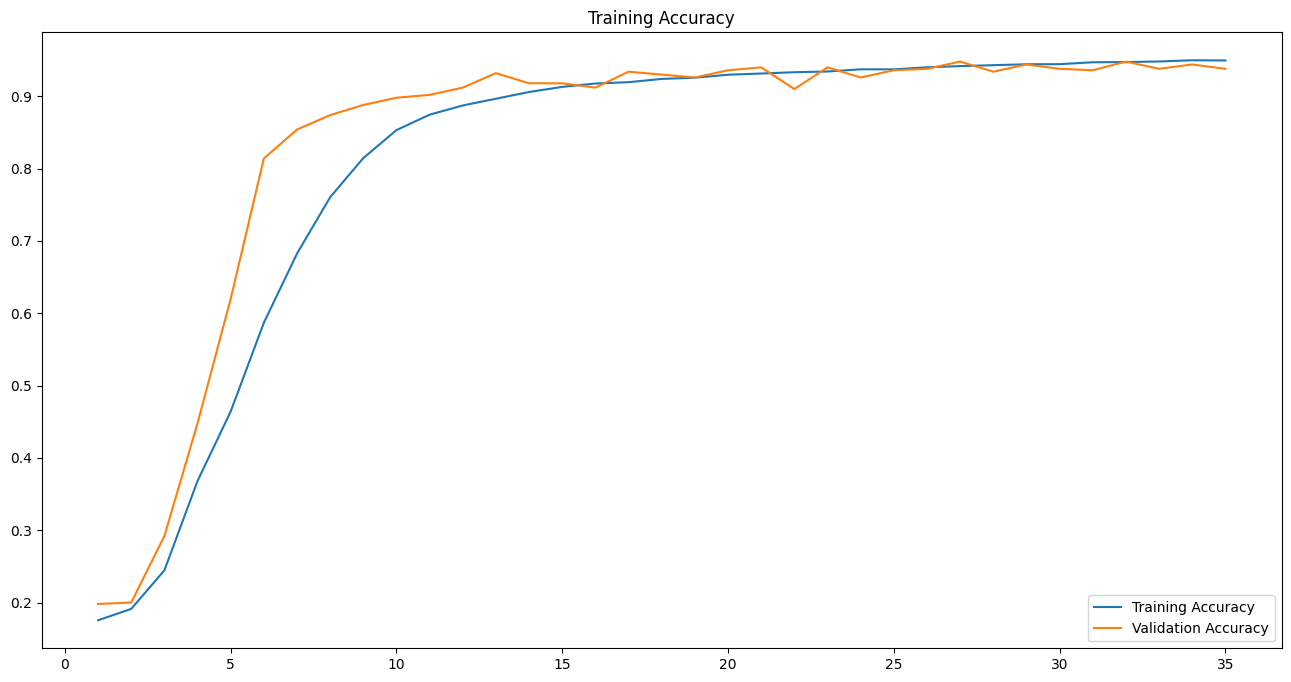

In [ ]:
show_results(model_history6)

Как мы видим, аугментация действительно помогает модели, однако надо лучше подбирать методы. Результат на тесте составил 0.935.

In [ ]:
save_test_pred(model, 5)

782/782 [==============================] - 3s 4ms/step


#### Базовая модель со skip-connection, удалением шума и датагеном (70 эпох)

После успеха прошлой модели мы можем попробовать увеличить количество эпох для обучения

In [ ]:
tf.keras.backend.clear_session()
inp =  tf.keras.layers.Input(shape=(32, 32, 3))
la1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3))(inp)
la2 = tf.keras.layers.BatchNormalization()(la1)
la3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la2)
la4 = tf.keras.layers.MaxPooling2D((2, 2))(la3)
laforadd1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la4)
add1 = tf.keras.layers.Add()([la4, laforadd1])
la5 = tf.keras.layers.Dropout(0.3)(add1)
la6 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la5)
la7 = tf.keras.layers.BatchNormalization()(la6)
la8 = tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu')(la7)
la9 = tf.keras.layers.MaxPooling2D((2, 2))(la8)
laforadd2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la9)
add2 = tf.keras.layers.Add()([la9, laforadd2])
la10 = tf.keras.layers.Dropout(0.3)(add2)
la11 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la10)
la12 = tf.keras.layers.BatchNormalization()(la11)
la13 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu')(la12)
la14 = tf.keras.layers.MaxPooling2D((2, 2))(la13)
laforadd3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la14)
add3 = tf.keras.layers.Add()([la14, laforadd3])
la15 = tf.keras.layers.Dropout(0.3)(add3)
la16 = tf.keras.layers.Flatten()(la15)
la17 = tf.keras.layers.Dense(128, activation='relu')(la16)
la18 = tf.keras.layers.Dropout(0.4)(la17)
la19 = tf.keras.layers.Dense(10,  activation='softmax')(la18)
model = tf.keras.Model(inputs=inp, outputs=la19)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['batch_normalization[0][0]']

In [ ]:
model_history7 = model.fit_generator(datagen.flow(train_images, train_labels, batch_size=batch_size),
                                  epochs=70, validation_data=(validation_images, validation_labels),
                                  callbacks=[])

/tmp/ipykernel_724015/3272698673.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history7 = model.fit_generator(datagen.flow(train_images, train_labels, batch_size=batch_size),


Epoch 1/70


2022-12-23 10:08:04.584557: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


97/97 [==============================] - 41s 353ms/step - loss: 2.3968 - accuracy: 0.1729 - val_loss: 2.2503 - val_accuracy: 0.1980
Epoch 2/70
97/97 [==============================] - 33s 344ms/step - loss: 2.1912 - accuracy: 0.2055 - val_loss: 2.2543 - val_accuracy: 0.1360
Epoch 3/70
97/97 [==============================] - 30s 305ms/step - loss: 1.8453 - accuracy: 0.3392 - val_loss: 2.1220 - val_accuracy: 0.3040
Epoch 4/70
97/97 [==============================] - 25s 252ms/step - loss: 1.4604 - accuracy: 0.5071 - val_loss: 1.3314 - val_accuracy: 0.6100
Epoch 5/70
97/97 [==============================] - 22s 231ms/step - loss: 1.0767 - accuracy: 0.6310 - val_loss: 0.7567 - val_accuracy: 0.7880
Epoch 6/70
97/97 [==============================] - 21s 215ms/step - loss: 0.8602 - accuracy: 0.7143 - val_loss: 0.6009 - val_accuracy: 0.8500
Epoch 7/70
97/97 [==============================] - 20s 208ms/step - loss: 0.7148 - accuracy: 0.7708 - val_loss: 0.4221 - val_accuracy: 0.8800
Epoch 8/70

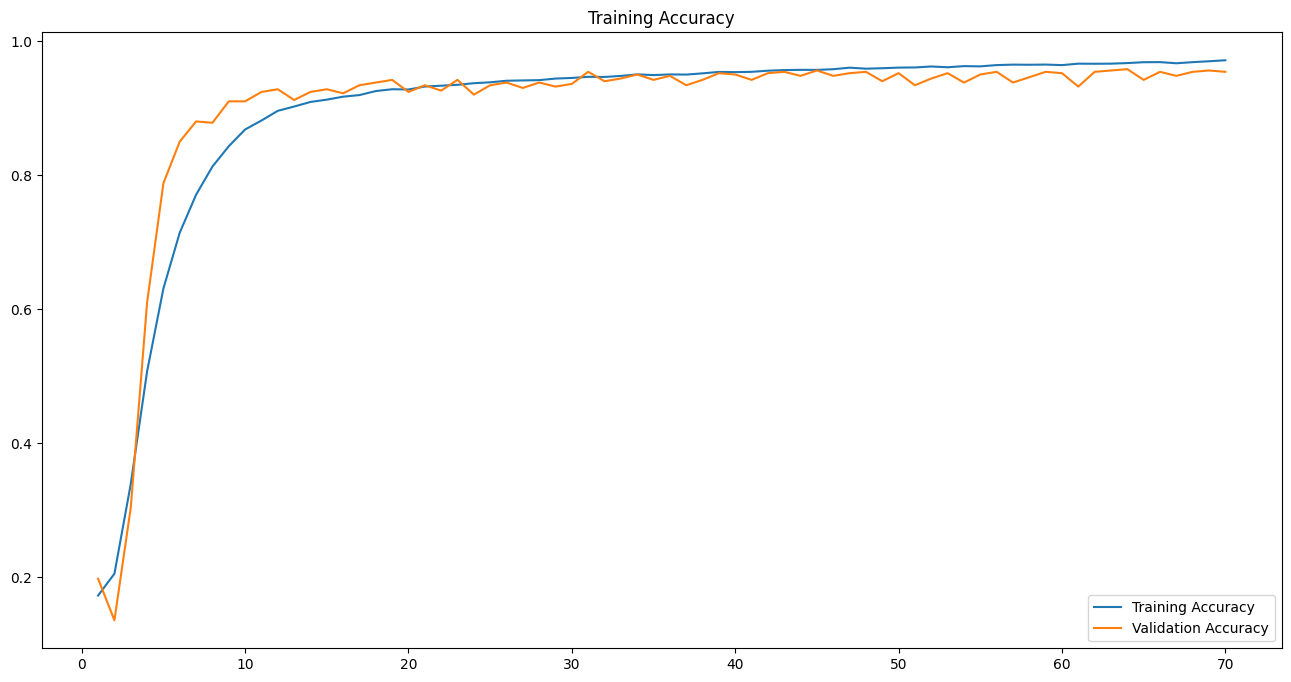

In [ ]:
show_results(model_history7)

Этот эксперимент доказывает, что иногда для получения большей точности достаточно просто подождать больший промежуток времени! Результат на тесте - 0.938

In [ ]:
save_test_pred(model, 6)

782/782 [==============================] - 4s 5ms/step


### Автоаугментация

Данный пункт содержит в себе настройку и применение автоаугментации, необходимой, чтобы как можно быстрее расширить количество данных для обучения (до нескольких десятков раз), что способствует улучшению работы нейронной сети 

Алгоритмы агументации основаны на данной статье: https://arxiv.org/pdf/1805.09501.pdf

#### Непосредственно аугментация

Ниже представлены классы, методы и функции, которые и позволяют нам реализовать автоаугментацию

* смещение по Oу
* сдвиги
* повороты
* изменение цвета
* постеризование
* соляризование
* изменение контраста
* изменение четкости
* изменение яркости
* выравнивание
* инвертирование

Класс получает изображение и подпирает, какие действия можно выполнить

In [ ]:
class SVHNPolicy(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](Image.fromarray(img))

Класс выбирает, какое из двух действий выполнить и определяет характеристики изменения

In [ ]:
class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        func = {
            "shearY": ShearY(fillcolor=fillcolor),
            "translateX": TranslateX(fillcolor=fillcolor),
            "translateY": TranslateY(fillcolor=fillcolor),
            "rotate": Rotate(),
            "color": Color(),
            "posterize": Posterize(),
            "solarize": Solarize(),
            "contrast": Contrast(),
            "sharpness": Sharpness(),
            "brightness": Brightness(),
            "autocontrast": AutoContrast(),
            "equalize": Equalize(),
            "invert": Invert()
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if random.random() < self.p1:
            img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2:
            img = self.operation2(img, self.magnitude2)
        return img

Ниже представлены классы, которые отвечают за непосредственное изменение изображения

In [ ]:
class ShearY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class TranslateX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, magnitude * x.size[0] * random.choice([-1, 1]), 0, 1, 0),
            fillcolor=self.fillcolor)


class TranslateY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * x.size[1] * random.choice([-1, 1])),
            fillcolor=self.fillcolor)


class Rotate(object):
    def __call__(self, x, magnitude):
        rot = x.convert("RGBA").rotate(magnitude * random.choice([-1, 1]))
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(x.mode)


class Color(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Color(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Posterize(object):
    def __call__(self, x, magnitude):
        return ImageOps.posterize(x, magnitude)


class Solarize(object):
    def __call__(self, x, magnitude):
        return ImageOps.solarize(x, magnitude)


class Contrast(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Contrast(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Sharpness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Sharpness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Brightness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Brightness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class AutoContrast(object):
    def __call__(self, x, magnitude):
        return ImageOps.autocontrast(x)


class Equalize(object):
    def __call__(self, x, magnitude):
        return ImageOps.equalize(x)


class Invert(object):
    def __call__(self, x, magnitude):
        return ImageOps.invert(x)

#### Работаем с данными

Уберем все примененные ранее фильтры

In [ ]:
img_data_train = objects_data_train['images']
lbl_data_train = objects_data_train['labels']
img_data_test = objects_data_test['images']

Уберем шум

In [ ]:
for i in range(len(img_data_train)):
    img_data_train[i] = cv2.medianBlur(img_data_train[i], 3)

In [ ]:
for i in range(len(img_data_test)):
    img_data_test[i] = cv2.medianBlur(img_data_test[i], 3)

Ниже представлен алгоритм, с помощью которого мы увеличиваем в 2 раза датасет для обучения, используя различные методы аугментации. Процесс этот очень долгий, но оно того стоит

In [ ]:
policy = SVHNPolicy()
img_data_train = img_data_train.astype('uint8')
imgs = img_data_train
lbls = lbl_data_train
for i in range(1):
    img_data_train = np.concatenate((img_data_train, np.array(list(map(lambda x: np.asarray(policy(x)), imgs))).astype('uint8')))
    lbl_data_train = np.concatenate((lbl_data_train, lbls))

/tmp/ipykernel_724015/1180781363.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
/tmp/ipykernel_724015/2635673718.py:7: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  x.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
/tmp/ipykernel_724015/2635673718.py:8: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.B

Приведем данные к стандартному виду

In [ ]:
img_data_train = img_data_train.astype('float')
img_data_train /= 255.0
img_data_test /= 255.0

#### Модель

Теперь мы можем на примере посмотреть на улучшение модели, однако, по-хорошему, на бы стоило усилить автоаугментацию, но, к сожалению, это очень ресурсозатратный процесс, поэтому мы остановились на 1-й итерации

Повторим стандартные действия

In [ ]:
train_images, validation_images, train_labels, validation_labels = train_test_split(img_data_train, lbl_data_train, test_size=0.15, random_state=22)

In [ ]:
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

val_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 1024, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)

val_dataset = val_dataset.batch(batch_size)

In [ ]:
tf.keras.backend.clear_session()
inp =  tf.keras.layers.Input(shape=(32, 32, 3))
la1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3))(inp)
la2 = tf.keras.layers.BatchNormalization()(la1)
la3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la2)
la4 = tf.keras.layers.MaxPooling2D((2, 2))(la3)
laforadd1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la4)
add1 = tf.keras.layers.Add()([la4, laforadd1])
la5 = tf.keras.layers.Dropout(0.3)(add1)
la6 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la5)
la7 = tf.keras.layers.BatchNormalization()(la6)
la8 = tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu')(la7)
la9 = tf.keras.layers.MaxPooling2D((2, 2))(la8)
laforadd2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la9)
add2 = tf.keras.layers.Add()([la9, laforadd2])
la10 = tf.keras.layers.Dropout(0.3)(add2)
la11 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la10)
la12 = tf.keras.layers.BatchNormalization()(la11)
la13 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu')(la12)
la14 = tf.keras.layers.MaxPooling2D((2, 2))(la13)
laforadd3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la14)
add3 = tf.keras.layers.Add()([la14, laforadd3])
la15 = tf.keras.layers.Dropout(0.3)(add3)
la16 = tf.keras.layers.Flatten()(la15)
la17 = tf.keras.layers.Dense(128, activation='relu')(la16)
la18 = tf.keras.layers.Dropout(0.4)(la17)
la19 = tf.keras.layers.Dense(10,  activation='softmax')(la18)
model = tf.keras.Model(inputs=inp, outputs=la19)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=8)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['batch_normalization[0][0]']

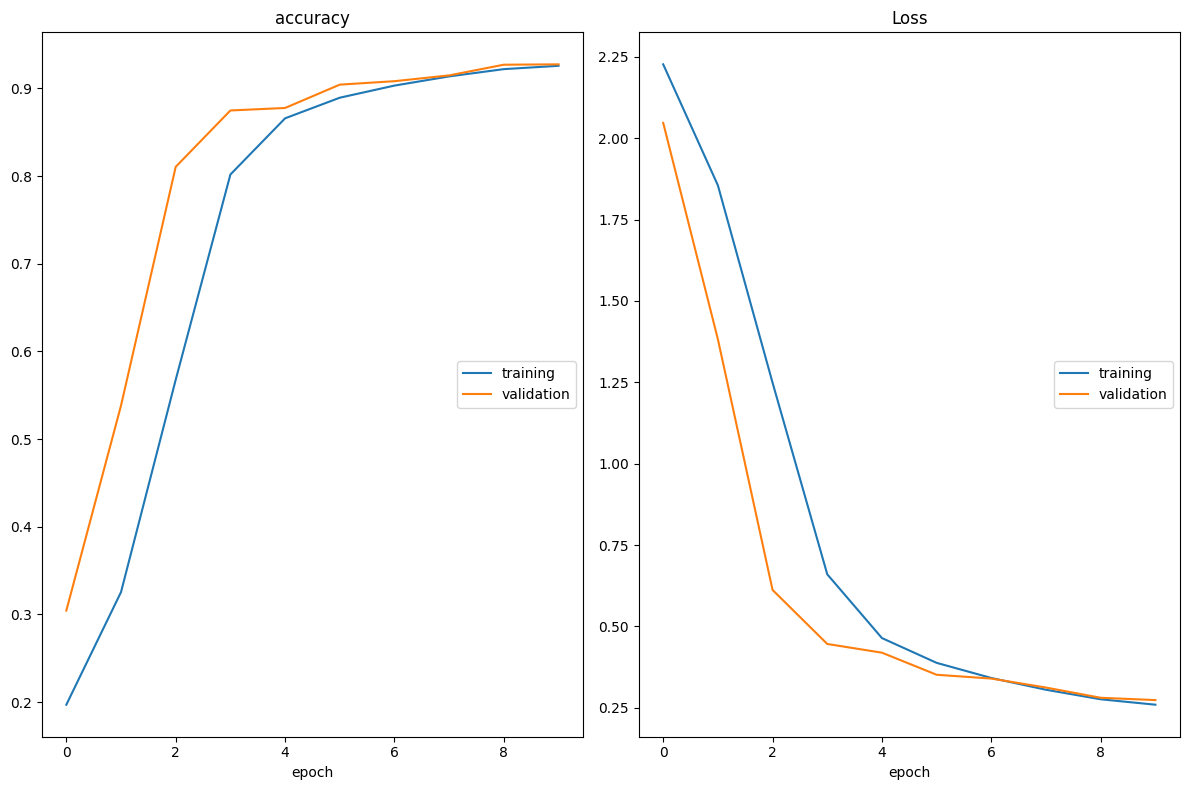

accuracy
	training         	 (min:    0.197, max:    0.926, cur:    0.926)
	validation       	 (min:    0.304, max:    0.927, cur:    0.927)
Loss
	training         	 (min:    0.260, max:    2.227, cur:    0.260)
	validation       	 (min:    0.274, max:    2.047, cur:    0.274)


In [ ]:
model_history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping, PlotLossesKeras()], verbose=False)

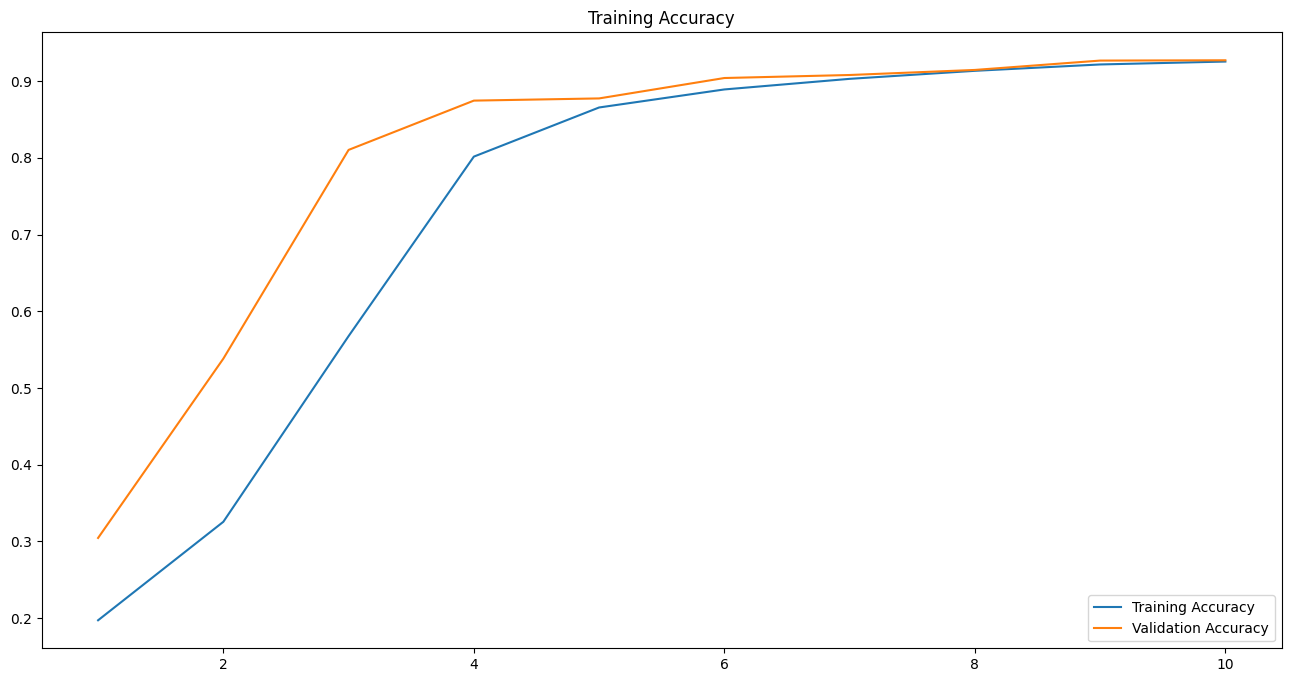

In [ ]:
show_results(model_history)

По графику видно, что такая аугментация приносит много пользы, однако процесс обучения длится очень долго, он является очень ресурсозатратным, поэтому мы используем небольшое количество эпох и слабую аугментацию (мы делали 29 измененых копий для каждого изображения, это можно будет увидеть ниже). Мы видим довольно быстрый рост точности! Результаты на тесте были более 0.94!

In [ ]:
save_test_pred(model, 7)

782/782 [==============================] - 4s 5ms/step


### Test-Time Augmentation

Этот пункт содержит только один класс, который реализует возможности TTA. Он используется для наиболее точного предсказания, т.к. оно происходит для целого ряда изображений, которые совсем немного отличаются от данного.

О том, как правильно составлять алгоритм TTA можно ознакомиться по данной ссылке: https://stepup.ai/test_time_data_augmentation/

In [ ]:
class TTA_ModelWrapper():
    def __init__(self, model, fillcolor=(128, 128, 128)):
        self.model = model

    def predict(self, X):
        policy = SVHNPolicy()
        imgs = X.astype('uint8')
        res = self.model.predict(X / 255.0)
        for _ in range(7):
            res += model.predict(np.array(list(map(lambda x: np.asarray(policy(x)), imgs))).astype('float') / 255.0)
        return  res / 8

Благодаря многочисленным экспериментам мы выяснили, что лучше всего создавать 7 измененных копий изображения, если поставить другие числа, то результат мог немного уменьшится или даже стать хуже, чем если не использовать TTA вовсе

### Модель

В этом пункте показана наша конечная модель, в которой мы постарались собрать только самые лучшие технологии, что бы смогли реализовать

Для наилучшего понимания того, что требуется для работы нашего решения, мы повторим все основные этапы по предобработке данных и выполним все стандартные действия

In [ ]:
img_data_train = objects_data_train['images']
lbl_data_train = objects_data_train['labels']
img_data_test = objects_data_test['images']

In [ ]:
for i in range(len(img_data_test)):
    img_data_test[i] = cv2.medianBlur(img_data_test[i], 3)

In [ ]:
for i in range(len(img_data_train)):
    img_data_train[i] = cv2.medianBlur(img_data_train[i], 3)

In [ ]:
policy = SVHNPolicy()
img_data_train = img_data_train.astype('uint8')
imgs = img_data_train
lbls = lbl_data_train
for i in range(29):
    img_data_train = np.concatenate((img_data_train, np.array(list(map(lambda x: np.asarray(policy(x)), imgs))).astype('uint8')))
    lbl_data_train = np.concatenate((lbl_data_train, lbls))

In [ ]:
img_data_train = img_data_train.astype('float')
img_data_train /= 255.0

In [ ]:
train_images, validation_images, train_labels, validation_labels = train_test_split(img_data_train, lbl_data_train, test_size=0.05, random_state=22)

In [ ]:
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

val_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 1024, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)

val_dataset = val_dataset.batch(batch_size)

In [ ]:
tf.keras.backend.clear_session()
inp =  tf.keras.layers.Input(shape=(32, 32, 3))
la1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3))(inp)
la2 = tf.keras.layers.BatchNormalization()(la1)
la3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la2)
la4 = tf.keras.layers.MaxPooling2D((2, 2))(la3)
laforadd1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(la4)
add1 = tf.keras.layers.Add()([la4, laforadd1])
la5 = tf.keras.layers.Dropout(0.3)(add1)
la6 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la5)
la7 = tf.keras.layers.BatchNormalization()(la6)
la8 = tf.keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu')(la7)
la9 = tf.keras.layers.MaxPooling2D((2, 2))(la8)
laforadd2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(la9)
add2 = tf.keras.layers.Add()([la9, laforadd2])
la10 = tf.keras.layers.Dropout(0.3)(add2)
la11 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la10)
la12 = tf.keras.layers.BatchNormalization()(la11)
la13 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu')(la12)
la14 = tf.keras.layers.MaxPooling2D((2, 2))(la13)
laforadd3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(la14)
add3 = tf.keras.layers.Add()([la14, laforadd3])
la15 = tf.keras.layers.Dropout(0.3)(add3)
la16 = tf.keras.layers.Flatten()(la15)
la17 = tf.keras.layers.Dense(128, activation='relu')(la16)
la18 = tf.keras.layers.Dropout(0.4)(la17)
la19 = tf.keras.layers.Dense(10,  activation='softmax')(la18)
model = tf.keras.Model(inputs=inp, outputs=la19)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('kaggle/working/best_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model_history = model.fit(train_dataset, validation_data=val_dataset, epochs=500, callbacks=[model_checkpoint, PlotLossesKeras()], verbose=False)

In [ ]:
acc = model_history.history["accuracy"]
val_acc = model_history.history['val_accuracy']
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1, len(acc) + 1), acc, label='Training Accuracy')
plt.plot(np.arange(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.show()

In [ ]:
tta_model = TTA_ModelWrapper(model)
model.save('best_model.h5')
predictions = tta_model.predict(img_data_test)
dict_pred = {}
for i in range(len(predictions)):
    dict_pred[i] = np.argmax(predictions[i])
with open('output_best.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar=',', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Id', 'Category'])
    for key in list(dict_pred.keys()):
        spamwriter.writerow([key, dict_pred[key]])

К сожалению, повторить эксперимент с данной моделью очень тяжело, это очень ресурсозатратный процесс, который еще и занимает много времени (более 16 часов), поэтому мы не запустим вновь этот процесс, однако к нашему проекту прилагается сохраненная версия данной модели;)

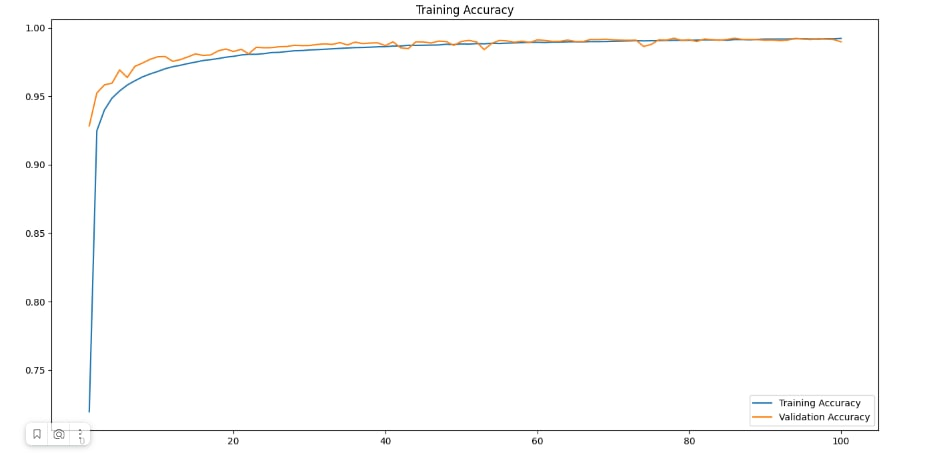

In [ ]:
from IPython.display import Image
Image("photo.jpg")

Также мы имеем возможность показать график обучения, именно так он выглядел во время эксперимента на 100 эпох. Из него мы видим серьезный рост точности и на трейне, и на валидации!

Именно эта модель является нашей финальной моделью, дальше мы будем только обрабатывать ее результаты для увеличения точности

### Как улучшить результат?

Казалось бы, мы написали модель, которая уже с достаточно высокой точностью угадывает цифру на изображении. Однако для мы можем эксперементировать с уже обученными моделями

Мода – наиболее часто встречающееся в числовом ряду значение. В нашем случае мы собрали все предсказания с лучших моделей (с автоаугментацией и TTA), обученных на разном количестве эпох (в это нам помог model_checkpoint). Так мы добились accuracy = 0.957 (В лидерборде после окончания соревнования мы можем видеть 0.96)

Стекинг — обучение нескольких разных алгоритмов и передача их результатов на вход последнему, который называют мета-алгоритмом. В данном случае мы сохраняли (как было видно выше) все модели и их чекпоинты (в большей степени использовались модели с АА). Так мы добились accuracy = 0.954

Ниже представлены функции, реализующие возможности стекинга, а также метод получения моды предсказаний

#### Стекинг

Данная функция возвращает ранее сохраненные модели

In [ ]:
def get_models():
    models = list()
    models.append(('model1', tf.keras.models.load_model("models/best_cnn (1).h5")))
    models.append(('model2', tf.keras.models.load_model("models/best_cnn (2).h5")))
    models.append(('model3', tf.keras.models.load_model("models/best_cnn (3).h5")))
    models.append(('model4', tf.keras.models.load_model("models/best_cnn (4).h5")))
    models.append(('model5', tf.keras.models.load_model("models/best_cnn (5).h5")))
    models.append(('model6', tf.keras.models.load_model("models/best_cnn (6).h5")))
    return models

Данная функция позволяет получить предсказания от каждой модели и на этой основе обучить мета-модель

In [ ]:
def fit_ensemble(models, X_val, y_val):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_val)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    blender = LogisticRegression()
    blender.fit(meta_X, y_val)
    return blender

Данная функуция возвращает предсказания мета-модели на тесте

In [ ]:
def predict_ensemble(models, blender, X_test):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_test / 255.0)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return blender.predict(meta_X)

### Мода

С помощью простейшего алгоритмы ниже мы можем получить моду предсказаний от файлов, однако перед этим требуется пронумировать все выходные .csv файлы с предсказаниями

In [ ]:
ar = {}
for i in range(1, 4):
    with open(f'{i}.csv', encoding="utf8") as csvfile:
        reader = list(csv.reader(csvfile, delimiter=';'))[1::]
        for j in reader:
            t = j[0].split(",")
            if t[0] not in ar:
                ar[t[0]] = [t[1]]
            else:
                ar[t[0]].append(t[1])
v = 0
viv = []
for i in ar:
    if len(set(ar[i])) == 1:
        viv.append(ar[i][1])
    else:
        t = list(map(lambda x: ar[i].count(x),ar[i]))
        viv.append(ar[i][t.index(max(t))])

## Выводы

Подводя итоги, хотелось бы указать те технологии, которые оказали наибольшее влияние на результат:
1. Skip-connection
2. Медианный фильтр
3. Autoaugmentation
4. Time-Test Augmentation
5. Использование моды (статистика)

В ходе работы над проектом нами были проведены эксперименты над различными моделями, здесь представлены не все из них, т.к. их было действительно много. Мы пытались использовать архитектуру WideResNet, улучшить модель с помощью SAM, однако это было безрезультатно. Они не прибавляли к точности практически ничего или вовсе вредили. Они не были упомянуты в работе, т.к. не получили никакого продолжения и были полностью нами отвергнуты как неэффективные в нашем конкретном случае. 

Нами была проведена огромная работа по разработке сверточной нейронной сети. Каждый участник команды проявил свой ум и смекалку для достижения общей цели, обучение и модернизация сетей не останавливалась даже ночью, т.к. все стремились обеспечить как качество, так и количество.